In [1]:
import numpy as np
import cv2
import json
from mrcnn import visualize, utils
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
results_path = '/home/incendio/Desktop/inference_results/split_rgb_results/binary_loss_results/results.json'
ground_truth_path = '/home/incendio/Desktop/inference_results/split_rgb_results/binary_loss_results/ground_truth.json'
with open(results_path, 'r') as f:
    results = json.load(f)
    
with open(ground_truth_path, 'r') as f:
    ground_truth = json.load(f)

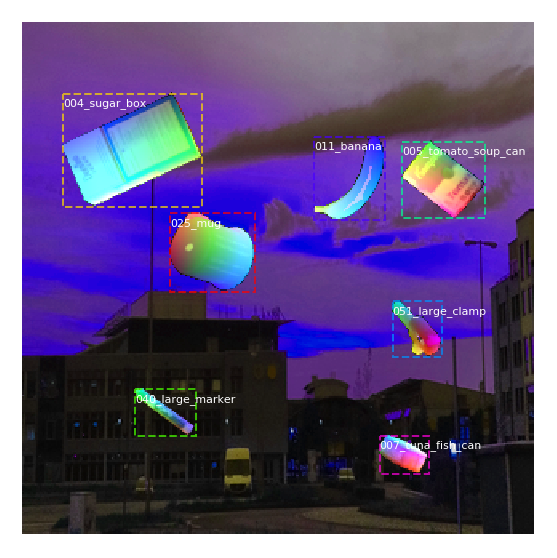

In [3]:
class_names = ['background', '002_master_chef_can', '003_cracker_box',
               '004_sugar_box', '005_tomato_soup_can', '006_mustard_bottle',
               '007_tuna_fish_can', '008_pudding_box', '009_gelatin_box',
               '010_potted_meat_can', '011_banana', '019_pitcher_base',
               '021_bleach_cleanser', '024_bowl',
               '025_mug', '035_power_drill',
               '036_wood_block', '037_scissors',
               '040_large_marker', '051_large_clamp',
               '052_extra_large_clamp', '061_foam_brick']

img_path = '/home/incendio/Desktop/inference_results/split_rgb_results/binary_loss_results/image.png'
img = cv2.imread(img_path)
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gt = ground_truth
gt_box = np.array(gt['rois'])
gt_class_id = np.array(gt['class_ids'])
r_mask = np.array(gt['gt_r_masks'])
r_mask = (r_mask * 255).astype(np.uint8)
g_mask = np.array(gt['gt_g_masks'])
g_mask = (g_mask * 255).astype(np.uint8)
b_mask = np.array(gt['gt_b_masks'])
b_mask = (b_mask * 255).astype(np.uint8)
masks = []
for i in range(r_mask.shape[-1]):
    mask = np.stack([r_mask[:, :, i], g_mask[:, :, i], b_mask[:, :, i]], axis=2)
    masks.append(mask)
masks = np.stack(masks, axis=2)
masks = np.reshape(masks, (320, 320, 3*7))
visualize.display_rgb_instances(image, gt_box, masks, gt_class_id, class_names, figsize=(10, 10))

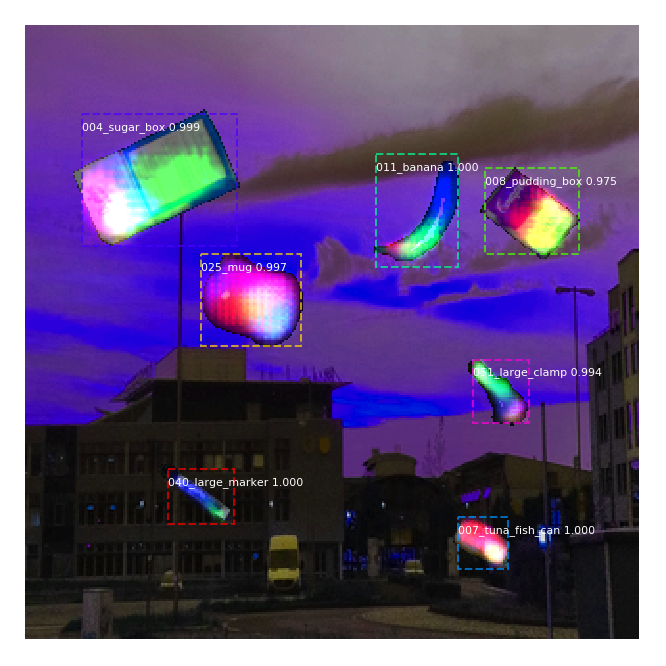

In [4]:
r = results
rois = np.array(r['rois'])
class_ids = np.array(r['class_ids'])
N = len(class_ids)

r_masks = np.array(r['r_masks'])
g_masks = np.array(r['g_masks'])
b_masks = np.array(r['b_masks'])
r_masks = (r_masks * 255).astype(np.uint8)
g_masks = (g_masks * 255).astype(np.uint8)
b_masks = (b_masks * 255).astype(np.uint8)
# for x in range(r_masks.shape[-1]):
#     plt.figure(figsize=(8,8))
#     plt.imshow(np.stack([r_masks[:, :, x], g_masks[:, :, x], b_masks[:, :, x]], axis=2))
#     plt.show()

masks = []
for i in range(r_masks.shape[-1]):
    masks.append(np.stack([r_masks[:, :, i], g_masks[:, :, i], b_masks[:, :, i]], axis=2))
masks = np.stack(masks)
visualize.display_test_instances(image, rois, masks, class_ids, class_names, results['scores'], figsize=(12, 12))

In [5]:
# g_masks = np.array(r['g_masks'])[0]
# b_masks = np.array(r['b_masks'])[0]

# mask_shape = r_masks.shape
# r_masks = np.reshape(r_masks, (-1, mask_shape[2], mask_shape[3], mask_shape[4]))
# g_masks = np.reshape(g_masks, (-1, mask_shape[2], mask_shape[3], mask_shape[4]))
# b_masks = np.reshape(b_masks, (-1, mask_shape[2], mask_shape[3], mask_shape[4]))

# r_masks = np.transpose(r_masks, [0, 3, 1, 2])
# g_masks = np.transpose(g_masks, [0, 3, 1, 2])
# g_masks = np.transpose(g_masks, [0, 3, 1, 2])
# r_masks = r_masks[np.arange(N), :, :, class_ids]
# g_masks = g_masks[np.arange(N), :, :, class_ids]
# b_masks = b_masks[np.arange(N), :, :, class_ids]
# print(r_masks.shape)
# plt.imshow(r_masks[0, :, :])
# plt.show()
# r_full_masks, g_full_masks, b_full_masks = [], [], []
# # r_full_masks = []
# original_image_shape = (320, 320, 3)
# for i in range(N):
#     r_full_mask = unmold_mask(r_masks[i], rois[i], original_image_shape)
#     g_full_mask = unmold_mask(g_masks[i], rois[i], original_image_shape)
# #     b_full_mask = unmold_mask(b_masks[i], rois[i], original_image_shape)
#     r_full_masks.append(r_full_mask)
#     g_full_masks.append(g_full_mask)
# #     b_full_masks.append(b_full_mask)
# print(r_full_masks[0].shape)
# r_full_masks = np.stack(r_full_masks, axis=-1)
# g_full_masks = np.stack(g_full_masks, axis=-1)
# # b_full_masks = np.stack(b_full_masks, axis=-1)
# print(r_full_masks.shape)

In [6]:
masks = []
for i in range(N):
    r = np.where(r_full_masks[:, :, i] > 0.05, r_full_masks[:, :, i], 0) * 255
    g = np.where(g_full_masks[:, :, i] > 0.05, g_full_masks[:, :, i], 0) * 255
#     b = np.where(b_full_masks[:, :, i] > 0.05, b_full_masks[:, :, i], 0) * 255
    masks.append(np.stack([r, g], axis=2))
masks = np.stack(masks)
# masks = np.where(masks>0.07, masks, 0) * 255
print(masks.shape)
print(class_ids[1])
plt.imshow(masks[0, :, :, 0])
plt.show()

NameError: name 'r_full_masks' is not defined

In [ ]:
# r_ = (np.where(r_masks >= 0.06, r_masks, 0))
# g = (np.where(g_masks >= 0.06, g_masks, 0))
# b = (np.where(b_masks >= 0.06, b_masks, 0))
# masks = []
# for i in range(r_masks.shape[-1]):
#     masks.append(np.stack([r_[:, :, i], g[:, :, i], b[:, :, i]], axis=2))
# masks = np.stack(masks)
# masks = masks * 255
# print(masks.shape)
# plt.imshow(masks[3])
# # cv2.imwrite('mask.png', masks[1])
# plt.show()
# print(masks.shape)
m = (masks).astype(np.uint8)
cv2.imwrite('m.png', m[:, :, 0])
print(np.unique(masks))
plt.imshow(m[:, :, 0])
plt.show()
visualize.display_instances(image, rois, m, class_ids, class_names, results['scores'], figsize=(12, 12), show_mask=True)

In [ ]:
#Post process masks
image_shape = (320, 320, 3)
masks = np.array(r['masks'])
rois = np.array(r['rois'])
masks = np.reshape(masks, (-1, 28, 28, 66))
new_masks = []
for i in range(len(class_ids)):
    m_id = class_ids[i] * 3
    new_masks.append(masks[i, :, :, m_id:m_id+3])
masks = np.stack(new_masks)
print(masks.shape)
full_masks = []
for i in range(len(class_ids)):
    full_mask = utils.unmold_mask(masks[i], rois[i], image_shape)
    full_masks.append(full_mask)
full_masks = np.stack(full_masks)
plt.imshow(full_masks[2])
plt.show()

In [ ]:
#Canny edge detection
y1, x1, y2, x2 = rois[2]
plt.figure(figsize=(5,5))
m = np.reshape(masks, (-1, 28, 28, 66))
m = (m[0, :, :, 60:63]*255).astype(np.uint8)
v = np.median(m)
sigma=0.33
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))

plt.imshow(cv2.Canny(m, lower, upper))
plt.show()

In [ ]:
masks = np.array(r['masks'])
mask_shape = masks.shape
print(mask_shape)
N = 4
positive_ids = np.repeat([0, 1, 2, 3], 3)
print(positive_ids)
class_ids = [16, 14, 15, 12]
mask_ids = []
for i in class_ids:
    mask_ids.append([i*3, i*3+1, i*3+2])
mask_ids = np.array(mask_ids).flatten()
print(mask_ids)



masks = np.reshape(masks, (-1, mask_shape[2], mask_shape[3], mask_shape[4]))
masks = np.transpose(masks, [0, 3, 1, 2])
# masks = masks[positive_ids, :, :, mask_ids]
print(masks.shape)
m = masks[0, 48, :, :]
plt.imshow(m)
plt.show()
# masks = np.transpose(masks, [0, 3, 1, 2])
# print(masks.shape)

# masks = masks[np.arange(N*3), mask_ids, :, :]
# print(masks.shape)

# masks = masks.T
# masks = np.reshape(masks, (-1, 28, 28, 3))

# full_masks = []
# for i in masks:
#     full_masks.append(utils.resize(i, (320, 320)))
# full_masks = np.stack(full_masks)
# # print(masks.shape)
# for i in full_masks:
#     plt.imshow(i)
#     plt.show()